## TRANSFORM DNA SEQUENCES TO SIGNALS

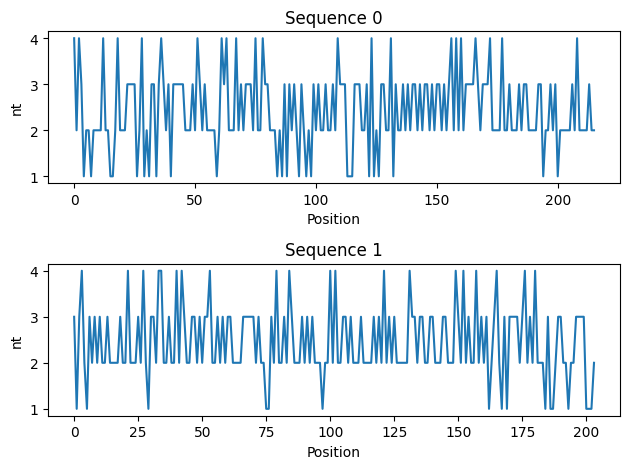

In [ ]:
import numpy as np
from typing import Union, List
import matplotlib.pyplot as plt
import pandas as pd

FASTA_PATH = '/path/to/sequences/file'

MAPPING_DICT = {"A": 1, "C": 2, "G": 3, "T": 4}
INVERSE_MAPPING_DICT = {1: "A", 2: "C", 3: "G", 4: "T"}

def extract_sequences_FASTA(fastafile: str):
    with open(fastafile, 'r') as fopen:
        return [line.upper().strip() for line in fopen if not line.startswith('>')]

def DNA2Signal(sequence: str) -> np.array:
    s = np.zeros(len(sequence))
    for i, nt in enumerate(sequence):
        s[i] = MAPPING_DICT[nt]
    return s

def display_sequences(sequences: Union[List[str], str]):

    if isinstance(sequences, str):
        sequences = [sequences]

    num_subplots = len(sequences)
    
    # Create subplots
    fig, axs = plt.subplots(num_subplots, 1)

    for i, ax in enumerate(axs):
        signal = DNA2Signal(sequences[i])
        ax.plot(signal)
        ax.set_title(f"Sequence {i}")
        ax.set_xlabel("Position")
        ax.set_ylabel("nt")

    plt.tight_layout()
    plt.show()

sequences = extract_sequences_FASTA(FASTA_PATH)
sequence = sequences[0:2]
display_sequences(sequence)

## VISUALIZE RESULTS OF GRADCAM

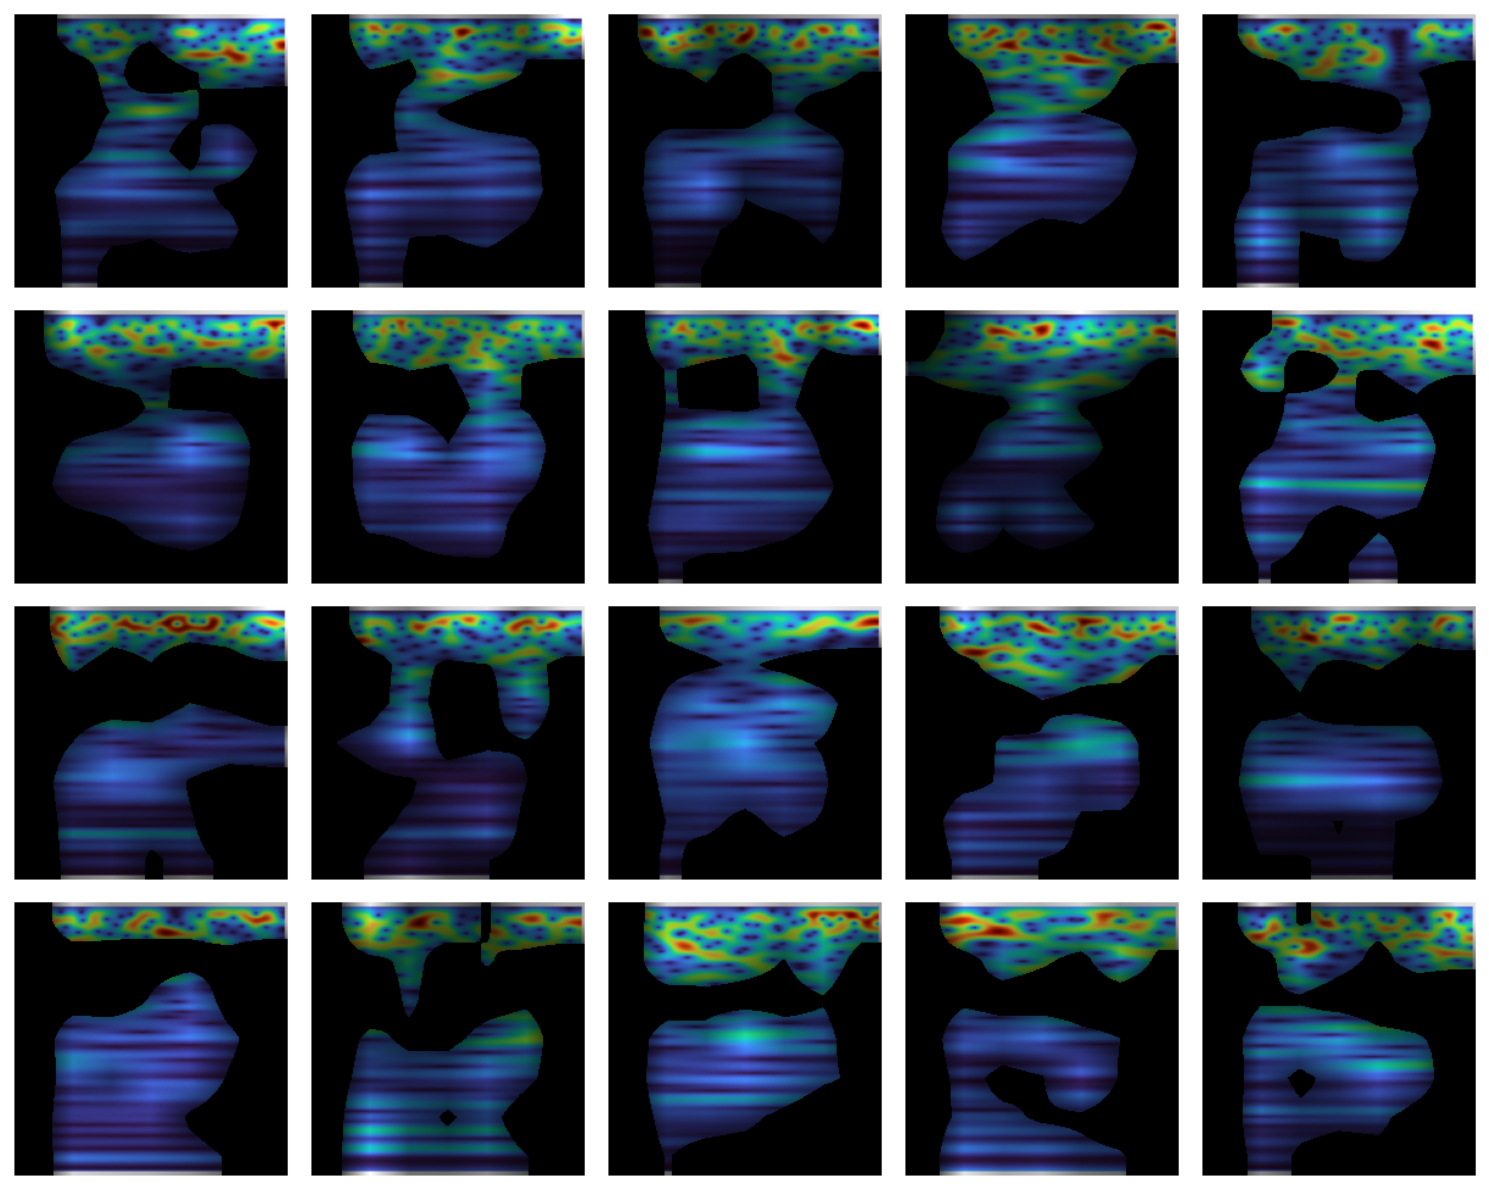

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

input_dir = "/path/to/images"
input_images = [Image.open(os.path.join(input_dir, image)) for image in os.listdir(input_dir)]

def plot_images_grid(images, output_fig, rows, cols):
    """
    Plots 20 images in a 4-row by 5-column grid.

    Parameters:
        images (list of np.array or PIL.Image): A list of 20 images.
    
    Returns:
        matplotlib.figure.Figure: The generated figure.
    """
    if rows * cols != len(images):
        raise ValueError(f"Cannot dispose {len(images)} in {rows * cols} boxes.")

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 12))

    for ax, img in zip(axes.flat, images):
        ax.imshow(img)  # Assumes images are in RGB format
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_axis_off()

    plt.tight_layout()
    # plt.savefig(output_fig, dpi=300)
    plt.show()
    plt.close()

plot_images_grid(input_images, '../xai/Layer_0_subplots.png', 4, 5)

## VISUALIZE RESULTS OF GRADCAM IN GIF FORMAT

Animation saved as prova.gif


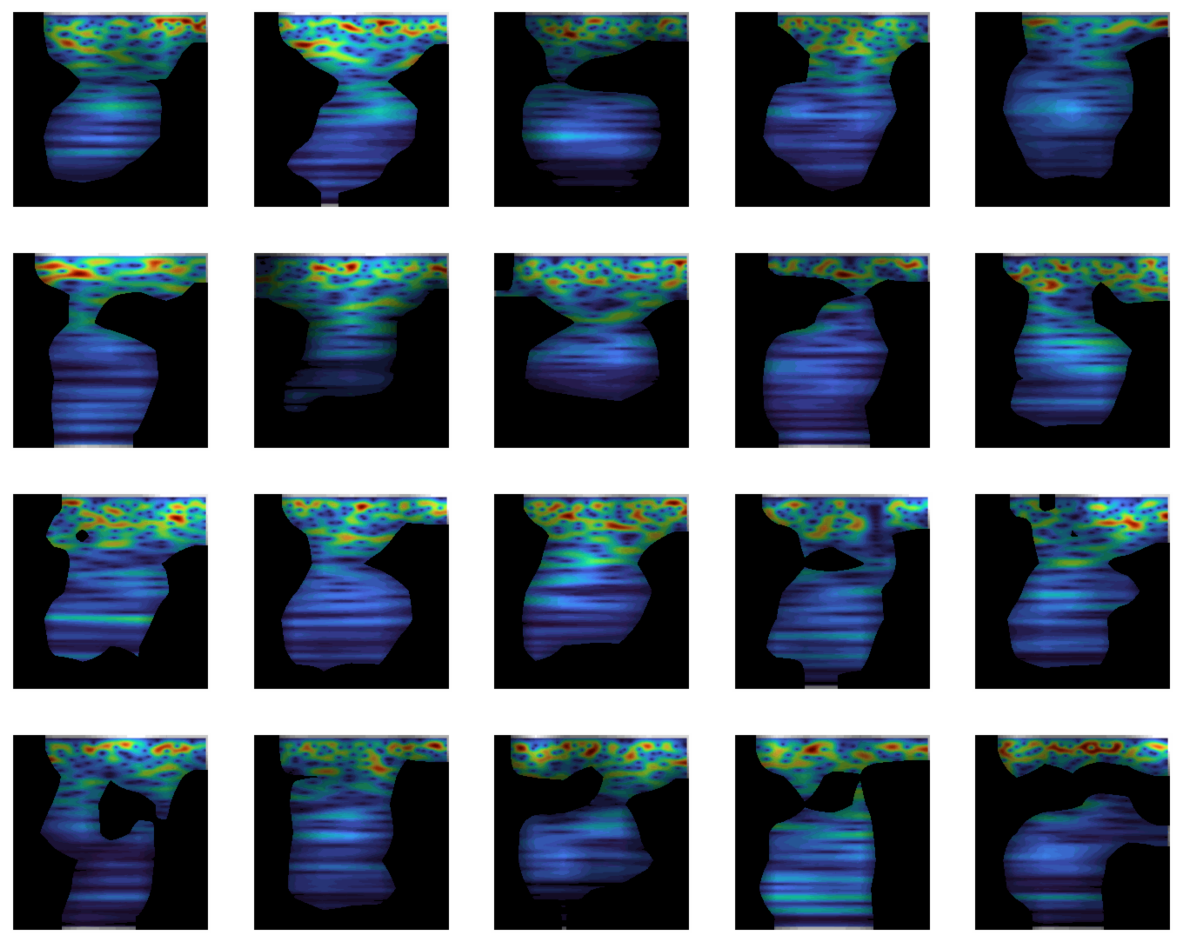

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import numpy as np

def plot_gif_animations(gif_paths, output_gif, rows, cols, fps=3):
    """
    Plots 20 animated GIFs in a 4x5 grid using matplotlib.animation.

    Parameters:
        gif_paths (list of str): A list of 20 file paths to GIF images.

    Returns:
        matplotlib.figure.Figure: The generated figure with animations.
    """
    if rows * cols != len(gif_paths):
        raise ValueError("The function requires exactly 20 GIF file paths.")

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 12))
    axes = axes.flatten()  # Flatten axes for easier indexing
    gif_frames = []  # To store frames for each GIF

    # Load GIFs and extract all frames
    for gif_path in gif_paths:
        img = Image.open(gif_path)
        frames = []
        try:
            while True:
                frames.append(np.array(img.convert("RGB")))  # Convert each frame to RGB
                img.seek(img.tell() + 1)  # Move to next frame
        except EOFError:
            pass  # End of frames

        gif_frames.append(frames)

    # Get the max number of frames in any GIF
    max_frames = max(len(frames) for frames in gif_frames)

    # Pad GIFs with their last frame if they have fewer frames
    for i in range(len(gif_frames)):
        while len(gif_frames[i]) < max_frames:
            gif_frames[i].append(gif_frames[i][-1])

    # Initialize each subplot with the first frame
    ims = []
    for ax, frames in zip(axes, gif_frames):
        im = ax.imshow(frames[0], animated=True)
        ax.axis("off")
        ims.append(im)

    # Animation update function
    def update(frame_idx):
        for im, frames in zip(ims, gif_frames):
            im.set_array(frames[frame_idx])
        return ims

    ani = animation.FuncAnimation(fig, update, frames=max_frames, interval=100, blit=True)

    # Save as GIF using PillowWriter
    ani.save(output_gif, writer=animation.PillowWriter(fps=fps))

    print(f"Animation saved as {output_gif}")
    plt.show()
    plt.close(fig)  # Close the figure to prevent it from displaying in the notebook

input_dir = '/path/to/gifs'
gif_files = [os.path.join(input_dir, gif) for gif in os.listdir(input_dir)]
plot_gif_animations(gif_files, "/path/to/saved/gif", 4, 5)

## GENERATE ONE GRADCAM IMAGE

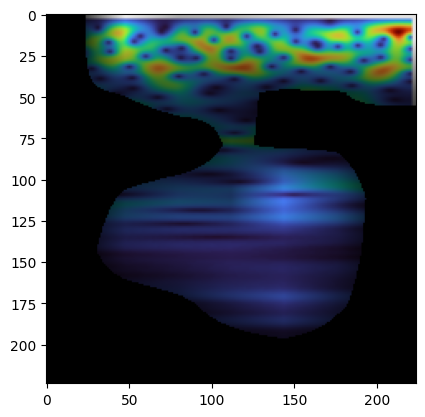

In [ ]:
import os
import sys
import torch as t
import numpy as np
import matplotlib.pyplot as plt
from imageio.v2 import get_writer, imread
from typing import List, Tuple, Optional
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from tqdm import tqdm
from natsort import natsorted
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

# Constants
MODEL_PATH = '/path/to/model'
IMAGE_SIZE = 224
device = 'cuda' if t.cuda.is_available() else 'cpu'

# Image transforms
transform_resnet = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(device))
])

transform_heatmap = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Lambda(lambda x: np.array(x) / 255)
])

def get_resnet_for_fine_tuning(num_classes: int) -> resnet50:

    pretrained_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

    # Set all requires_grad to false
    for param in pretrained_resnet.parameters():
        param.requires_grad = False

    # Override the fc layer with the number of classes
    pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, num_classes)

    # Set last layer and fc requires_grad to True
    for param in pretrained_resnet.layer4.parameters():
        param.requires_grad = True
    
    for param in pretrained_resnet.fc.parameters():
        param.requires_grad = True
    
    # Return the new model
    return pretrained_resnet

def load_model(model_path: str, num_classes: int = 2):
    """Load and prepare the model for inference."""
    model = get_resnet_for_fine_tuning(num_classes=num_classes)
    model.load_state_dict(t.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def generate_gradcam_image(model, input_tensor: t.Tensor, targets: List, rgb_img_np: np.array, layer):
    """Generate a Grad-CAM heatmap for a given model layer."""
    with GradCAM(model=model, target_layers=[layer]) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
        grayscale_cam = np.where(grayscale_cam > np.percentile(grayscale_cam, 50), grayscale_cam, 0)
        return rgb_img_np * np.expand_dims(grayscale_cam, axis=-1)

image_path = '/path/to/sample/image'
model = load_model(MODEL_PATH)
target_layers = [model.layer4[-3], model.layer4[-2], model.layer4[-1]]
targets = [ClassifierOutputTarget(0)]

rgb_img = Image.open(image_path).convert('RGB')
input_tensor = transform_resnet(rgb_img).unsqueeze(0)
rgb_img_np = transform_heatmap(rgb_img)

layer = model.layer4[-3]

output_image = generate_gradcam_image(model, input_tensor, targets, rgb_img_np, layer)
plt.imshow(output_image)